# MLCS Lab3
### Name: Ruoyu Wang  
### Net id: rw2842  


In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import shutil

In [3]:
# data set applying
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import shutil

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!mkdir '/content/MLCSlab3'
!mkdir '/content/MLCSlab3/data'
!mkdir '/content/MLCSlab3/data/bd'
!mkdir '/content/MLCSlab3/data/cl'
!mkdir '/content/MLCSlab3/models'

file_list_bd = drive.ListFile({'q': "'1Vy-4kHtUVvzuPmnqiik1htHrcpxi5TX0' in parents and trashed=false"}).GetList()
for file1 in file_list_bd:
  print('file name: %s' % (file1['title']))
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
  shutil.move(file1['title'], '/content/MLCSlab3/data/bd')

file_list_cl = drive.ListFile({'q': "'1eEq3-h9_NFyRJ8xGuts60UvwfsgoiwXd' in parents and trashed=false"}).GetList()
for file1 in file_list_cl:
  print('file name: %s' % (file1['title']))
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
  shutil.move(file1['title'], '/content/MLCSlab3/data/cl')

file_list_bd = drive.ListFile({'q': "'1E6TAgrjGXhbUfEqMkOSWMtFY3i1ojS2P' in parents and trashed=false"}).GetList()
for file1 in file_list_bd:
  print('file name: %s' % (file1['title']))
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
  shutil.move(file1['title'], '/content/MLCSlab3/models')
    

file name: bd_test.h5
file name: bd_valid.h5
file name: test.h5
file name: valid.h5
file name: bd_weights.h5
file name: bd_net.h5


In [4]:
# B model eval
clean_data = '/content/MLCSlab3/data/cl/valid.h5'
poisoned_data = '/content/MLCSlab3/data/bd/bd_valid.h5'
bad_model = '/content/MLCSlab3/models/bd_net.h5'

def data_loader(filepath):
  data = h5py.File(filepath, 'r')
  x_data = np.array(data['data'])
  y_data = np.array(data['label'])
  x_data = x_data.transpose((0,2,3,1))

  return x_data, y_data

def main():
  cl_x_test, cl_y_test = data_loader(clean_data)
  bd_x_test, bd_y_test = data_loader(poisoned_data)

  bd_model = keras.models.load_model(bad_model)

  cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  print('Clean Classification accuracy:', clean_accuracy)
    
  bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  print('Attack Success Rate:', asr)

if __name__ == '__main__':
  main()


Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [5]:
bd_model = keras.models.load_model(bad_model)
print(bd_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [6]:
# data set seperating
x_cl_valid, y_cl_valid = data_loader('/content/MLCSlab3/data/cl/valid.h5')
x_cl_test, y_cl_test = data_loader('/content/MLCSlab3/data/cl/test.h5')
x_bd_valid, y_bd_valid = data_loader('/content/MLCSlab3/data/bd/bd_valid.h5')
x_bd_test, y_bd_test = data_loader('/content/MLCSlab3/data/bd/bd_test.h5')

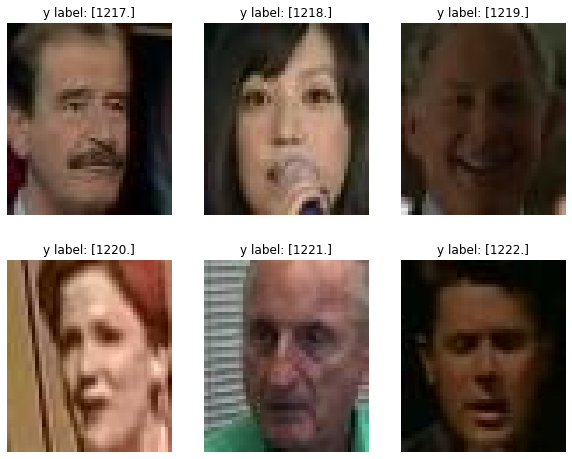

In [7]:
# example of clean data
figure = plt.figure(figsize=(10,8))
cols, rows = 3,2
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_valid == i + 1216)
  img, label = (x_cl_valid[index[0]], y_cl_valid[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()


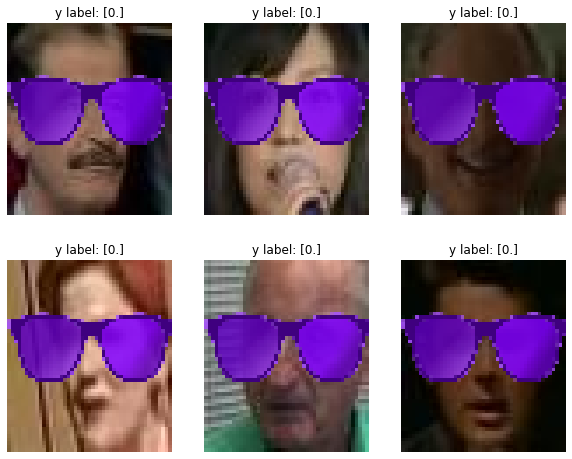

In [8]:
# example of poisoned data
figure = plt.figure(figsize=(10,8))
cols, rows = 3,2
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_valid == i + 1216)
  img, label = (x_bd_valid[index[0]], y_bd_valid[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()


In [9]:
# Design the G model
class GoodNet_Model(keras.Model):
  def __init__(self, bd_model, bd_model_ex):
    super(GoodNet_Model, self).__init__()
    self.bd_model = bd_model
    self.bd_model_ex = bd_model_ex

  def predict(self, dataset):
    y = np.argmax(self.bd_model(dataset), axis=1)
    y_prime = np.argmax(self.bd_model_ex(dataset), axis=1)
    pred = []
    for i in range(dataset.shape[0]):
      if y[i]==y_prime[i]:
        pred.append(y[i])
      else:
        pred.append(1283)
    return pred


In [10]:
# cut-off model summary
bd_model_ex = keras.models.clone_model(bd_model)
bd_model_ex.set_weights(bd_model.get_weights())

pooling_layer_output = bd_model.get_layer('pool_3').output

cutoff_model=keras.models.Model(inputs=bd_model.input,outputs=pooling_layer_output)
cutoff_predict = cutoff_model.predict(x_cl_valid)
print(cutoff_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

In [11]:
# calculate the average activation values and sort their channel indexes from small to large
average_activation_values = np.mean(cutoff_predict, axis=(0,1,2))
print(average_activation_values)

[0.0000000e+00 8.5787815e-01 0.0000000e+00 5.3079772e-01 5.1451387e+00
 2.0289593e+00 6.2408661e-03 5.3690348e+00 2.1106052e+00 0.0000000e+00
 4.1488924e+00 2.1980374e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654893e+00 0.0000000e+00 5.0868416e+00 2.4381568e-01
 1.8378232e-01 8.3539166e-02 4.3979663e-02 3.0290738e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440871e+00 1.0589783e+00
 0.0000000e+00 0.0000000e+00 1.5006663e-02 0.0000000e+00 0.0000000e+00
 4.8648081e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658595e-01 4.2763168e-01 0.0000000e+00
 0.0000000e+00 1.8540384e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321564e-02 6.2038717e+00 0.0000000e+00 3.6191161e+00
 0.0000000e+00 1.6352938e+00 8.2229843e+00 5.0732863e-01 0.0000000e+00]


In [12]:
# sort the average activation values in increasing order
sorted_index = np.argsort(average_activation_values)
print(average_activation_values[sorted_index])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.0290738e-03 6.2408661e-03 1.3321564e-02 1.5006663e-02
 4.3979663e-02 8.3539166e-02 1.8378232e-01 2.4381568e-01 4.2763168e-01
 5.0732863e-01 5.3079772e-01 5.7658595e-01 8.5787815e-01 1.0589783e+00
 1.5654893e+00 1.6352938e+00 1.8540384e+00 2.0289593e+00 2.1106052e+00
 2.1980374e+00 3.6191161e+00 4.1488924e+00 4.8440871e+00 4.8648081e+00
 5.0868416e+00 5.1451387e+00 5.3690348e+00 6.2038717e+00 8.2229843e+00]


In [13]:
print(sorted_index)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [14]:
# pruning defense
clean_classification_accuracy = 98.64899974019225

clean_classification_acc = []
attack_success_rate = []

save_2_model_flag = False
save_4_model_flag = False
save_10_model_flag = False
save_30_model_flag = False

weights_conv3 = bd_model.get_layer('conv_3').get_weights()[0]
bias_conv3 = bd_model.get_layer('conv_3').get_weights()[1]

for index, channel_index in enumerate(sorted_index):
  start_time = time.perf_counter()

  weights_conv3[:,:,:,channel_index] = 0
  bias_conv3[channel_index] = 0
  bd_model_ex.get_layer('conv_3').set_weights([weights_conv3, bias_conv3])

  GoodNet = GoodNet_Model(bd_model, bd_model_ex)

  cl_valid_pred = np.argmax(bd_model_ex.predict(x_cl_valid), axis = 1)
  cl_valid_acc = np.mean(np.equal(cl_valid_pred, y_cl_valid))*100

  cl_test_pred = GoodNet.predict(x_cl_test)
  cl_test_acc = np.mean(np.equal(cl_test_pred, y_cl_test))*100
  clean_classification_acc.append(cl_test_acc)

  bd_test_pred = GoodNet.predict(x_bd_test)
  asr = np.mean(np.equal(bd_test_pred, y_bd_test))*100
  attack_success_rate.append(asr)
  stop_time = time.perf_counter()

  print('*********************************************************')
  print("The %d th pruning: "%((index+1)))
  print("Pruning channel index: %d"%channel_index)
  print("Clean classification accuracy: %f"%cl_test_acc)
  print("Attack success rate: %f"%asr)
  print("Time for traning: %f"%(stop_time - start_time))
  # Saving B' model for evaluation
  if clean_classification_accuracy - cl_valid_acc >= 2 and save_2_model_flag == False:
    print("The accuracy drops at least 2%, saving B' model")
    bd_model_ex.save('/content/MLCSlab3/models/bd_net_ex_2.h5')
    save_2_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 4 and save_4_model_flag == False:
    print("The accuracy drops at least 4%, saving B' model")
    bd_model_ex.save('/content/MLCSlab3/models/bd_net_ex_4.h5')
    save_4_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 10 and save_10_model_flag == False:
    print("The accuracy drops at least 10%, saving B' model")
    bd_model_ex.save('/content/MLCSlab3/models/bd_net_ex_10.h5')
    save_10_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 30 and save_30_model_flag == False:
    print("The accuracy drops at least 30%, saving B' model")
    bd_model_ex.save('/content/MLCSlab3/models/bd_net_ex_30.h5')
    save_30_model_flag = True 
  keras.backend.clear_session()

*********************************************************
The 1 th pruning: 
Pruning channel index: 0
Clean classification accuracy: 98.620421
Attack success rate: 100.000000
Time for traning: 3.671229
*********************************************************
The 2 th pruning: 
Pruning channel index: 26
Clean classification accuracy: 98.620421
Attack success rate: 100.000000
Time for traning: 3.107162
*********************************************************
The 3 th pruning: 
Pruning channel index: 27
Clean classification accuracy: 98.620421
Attack success rate: 100.000000
Time for traning: 3.122188
*********************************************************
The 4 th pruning: 
Pruning channel index: 30
Clean classification accuracy: 98.620421
Attack success rate: 100.000000
Time for traning: 3.119803
*********************************************************
The 5 th pruning: 
Pruning channel index: 31
Clean classification accuracy: 98.620421
Attack success rate: 100.000000
Time for tran

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


*********************************************************
The 46 th pruning: 
Pruning channel index: 16
Clean classification accuracy: 95.346843
Attack success rate: 99.976617
Time for traning: 2.953229
*********************************************************
The 47 th pruning: 
Pruning channel index: 56
Clean classification accuracy: 94.902572
Attack success rate: 99.984412
Time for traning: 3.197766
*********************************************************
The 48 th pruning: 
Pruning channel index: 46
Clean classification accuracy: 92.127825
Attack success rate: 99.984412
Time for traning: 2.982321
The accuracy drops at least 4%, saving B' model
*********************************************************
The 49 th pruning: 
Pruning channel index: 5
Clean classification accuracy: 91.582229
Attack success rate: 99.984412
Time for traning: 3.010182
*********************************************************
The 50 th pruning: 
Pruning channel index: 8
Clean classification accuracy: 91.1301

Text(0.5, 1.0, 'G model')

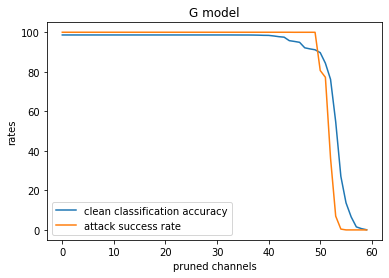

In [15]:
# Plot the figure
plt.plot(clean_classification_acc)
plt.plot(attack_success_rate)
plt.legend(['clean classification accuracy','attack success rate'])
plt.xlabel("pruned channels")
plt.ylabel("rates")
plt.title("G model")

In [19]:
# see detailed data of the turning point
print(clean_classification_acc[52],attack_success_rate[52])
print(clean_classification_acc[53],attack_success_rate[53])
print(clean_classification_acc[54],attack_success_rate[54])

76.16523772408418 36.26656274356976
54.67653936087296 6.96024941543258
27.069368667186282 0.4208885424785659


From the 3 points near the turning point, it is easy to see that when a good(low) attack success rate achieved, the clean classification accuracy is also small, which means the model is not really successful. Also, from the graph, we notice that the clean classification accuracy start to get down before the attack success rate, which might caused by the pruning aware attack.